# Snow profile for Crocus simulation.

___
This notebook aims to creat the initial snow profile used in Crocus simulaitons strated the 17-03-2025. To that a the snow profile output at the beggining of the season until the 17-03-2025 is used. Then this file is set with observed profile at col du Lauteret.
___
--- 
**Date** : 06/05/2025\
**Written** Glenn Pitiot
  
**Biblio used** : \
Version 3.0 of the Crocus snowpack model \

**Practical steps**:
* Import of oberved profile and creat a coherent profile for Crocus simulation
* Import of  the simul profile to change. 
* Apply change
* Save

---

# Libraries importation

In [24]:
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import re
import numpy as np


### PERSONAL SCRIPT ###

import sys
import os

# Ajoute le dossier parent du notebook au sys.path
sys.path.append(os.path.abspath("../"))  # Monte d'un niveau


from utils.load_data import load_PT100_data
from utils.Plot import plot_interpolated_heatmap_PT100
from utils.Plot import plot_multiple_days

from utils.utils import  manip_prep_Thickness_Snow

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# I definition of the snow profile

## I.1 Crocus definition
Prognostic variables for each layer in the Crocus simulation are:

- WSN_VEGX: Water content of layer X in kg/m²

- RSN_VEGX: Total density (water + ice) in kg/m³

- HSN_VEGX: Total enthalpy in J/m^3. The expression for enthalpy H as a function of temperature and water content is given in Equation (5) of the attached PDF (a paper in preparation describing Crocus)

- SAG_VEGX: Age of the layer (in days since snowfall)

- SG1_VEGX: Equivalent optical diameter (in meters)

- SG2_VEGX: Sphericity (value between 0 and 1)

- SHI_VEGX: "History" variable (an integer indicating whether the layer has encountered liquid water or not). We will decide what to assign based on the stratigraphy.

| State | Liquid water at any time before t | Faceted crystals at any time before t | More than one freezing-melting cycle before t |
|-------|-----------------------------------|---------------------------------------|-----------------------------------------------|
| 0     | No                                | No                                    | No                                            |
| 1     | No                                | Yes                                   | No                                            |
| 2     | Yes                               | No                                    | No                                            |
| 3     | Yes                               | Yes                                   | No                                            |
| 4     | Yes                               | No                                    | Yes                                           |
| 5     | Yes                               | Yes                                   | Yes                                           |


- ASN_VEG: Snowpack albedo.

Using diagnostic variables makes it simpler for this study to define each snow layer. For instance, we pinpoint the density, thickness, and temperature of a specific snow layer. With these diagnostic variables, it is possible to define Total Enthalpy as a prognostic variable.

These formula link variables are used

*  Water content of layer X in kg/m² : $m_{i} = \rho_{i}*z_i$
*  Total enthalpy in $J/m^3$ : \
  $H = [-L_m+(T_i-T_O)*C_I].\rho_{snow}$\
                  with : $L_{m} = 333.7*10^3 kJ/kg$ : latent heat of fusion, $C_I = 2.106 kJ.kg^{-1}.K^{-1}$ : ice thermal capacity
*  Equivalent optical diameter (in meters) : $r_{optical} = 3/SSA$\
                  with SSA in $m^{-1}$ : $ SSA = S/(V\rho_{ice})  [m²/kg]$ mesured from ASSAP
   

The profile is then save into a csv, which is import into this notebook

## I.2 Import of temperature profile.

(<Axes: >, <matplotlib.contour.QuadContourSet at 0x77de87f7a750>)

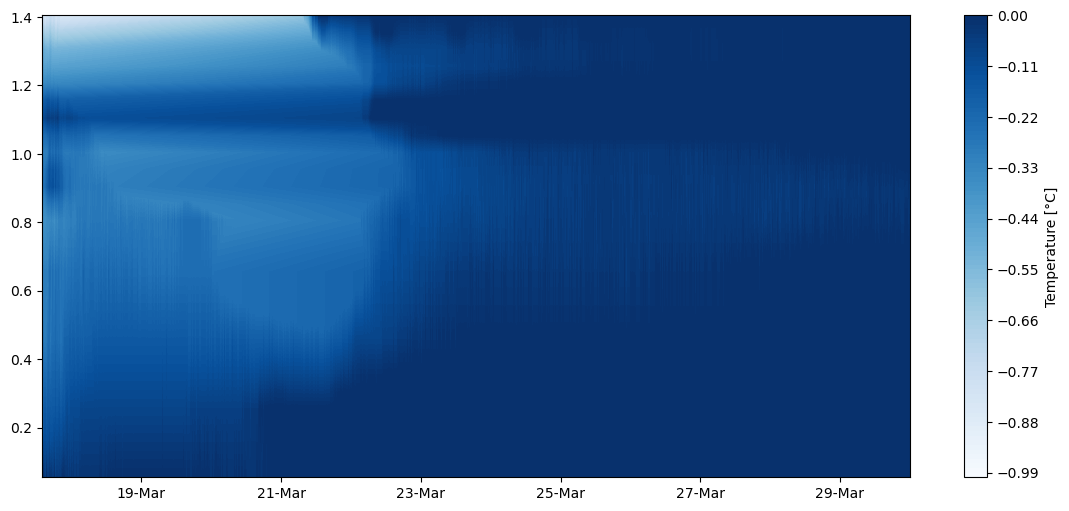

In [25]:
# Open the absolute_path of the file
absolute_path = "~/private-storage/Experiences/Lautaret/Lautaret_2025-04-08/data/"
name_path = "CR1000_Temp_CF.dat"
df_PT100 = load_PT100_data(absolute_path,name_path,"2025-03-10")

# Definition of PT100 position
Dic_PT100 = { 13 : '142 cm',
            12 : '132 cm',
            11  : '122 cm',
            10  : '112 cm',
            9 :'102 cm',
            8 :'92 cm',
            7:'82 cm',
            6:'65.5 cm',
            5:'45.5 cm',
            4:'25.5 cm',
            3:'5.5 cm'}
plot_interpolated_heatmap_PT100(df_PT100, Dic_PT100, date=('2025-03-17','2025-03-30'), resolution=0.05, vmin= -1 , vmax=0,cmap='Blues')

## 1.3 Import of profile for 17/03/2025

[<Axes: > <Axes: > <Axes: >]


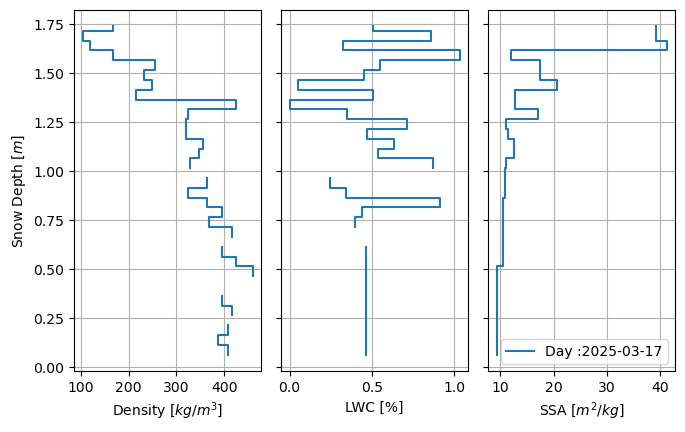

In [26]:
# DATA folder
data_folder = "~/private-storage/Data_internship_2025_GP/Campaign_CdL_2024-2025/Lautaret_concatenate-data/"

# List of campaigne days
Date = ['2025-03-17','2025-03-21','2025-03-31_12h44','2025-03-31_15h18','2025-04-01_10h00','2025-04-01_11h43','2025-04-02_11h30',"2025-04-08_9h30","2025-04-08_11h00","2025-04-08_13h00"]
# Création of a dic which store each df of a coresponding day
Dic_df_days={}
file_name = ".csv"
for date in Date:
    Dic_df_days[date] =  pd.read_csv(data_folder+'concatenate-data_cdl_'+date+".csv", delimiter=',',dtype=np.float64)
    

Date=['2025-03-17']
fig, axs=plot_multiple_days(Date,Dic_df_days)

# Save
picture_folder = os.path.expanduser("~/private-storage/Photo_rapport/")
os.makedirs(picture_folder, exist_ok=True)

fig.savefig(os.path.join(picture_folder, "Profil_def_for_crocus.png"),
            dpi=300, bbox_inches='tight')

## I.4 Import of csv file for profile snow 
This profile is then reproduced into the csv `PRO_definition_20250317`:

* Mean temperatures for each layer are used from the PT100
* SG2_VEG (sphericity): = 1 This means that all grains are considered as spheres
* SHI_VEG (age of the layer)  = Is set using a simulation for the beginning of the season until the 17/02/2025

In [27]:
# Read CSV
path = "~/private-storage/Data_internship_2025_GP/Crocus/Initial_profile_20250317/PRO_definition_20250317.csv"
prep_def = pd.read_csv(path, delimiter=';')

# Select only variables usefull:
target_variables = ["RSN_VEG",	"WSN_VEG",	"HSN_VEG",	"SAG_VEG",	"SG1_VEG",	"SG2_VEG",	"SHI_VEG"]
prep_def = prep_def[target_variables]


# I. Load snow profile from annual simulation
<p align="justify">
The <strong>PREP</strong> file defines all the variables needed for the initialization of the snowpack. 
<code>PREP_2025031706.nc</code> is the final snow profile from a Crocus simulation covering the period from 
<strong>October</strong> (the beginning of the season) to <strong>March 17, 2025</strong> (the first day of observation). 
It allows for a consistent initialization of the snow profile based on observed conditions.
</p>


In [35]:
#Personal-lab-book_Intership-2025_Glenn-Pitiot-/notebooks/Crocus/Simulation output/data
infile_name = "~/private-storage/Data_internship_2025_GP/Crocus/Initial_profile_20250317/PREP_2025031706.nc"
prep = xr.open_dataset(infile_name,decode_times=False)

## I.1 Some visualisation
### Snow height

In [29]:
manip_prep_Thickness_Snow(prep)

Thickness snow pack: 1.6022971792092138 m


# II Apply change into the PREP file.

## Change along all variable list

In [30]:
# Iteration under columns variable
index = prep_def.index
print(index+1)
for var in prep_def.columns:
    # Look for all snow layers 0-51
    for i in range(0, 52):
        var_name = var+f"{i}"
        if var_name in prep and i in index+1 :
            values = prep[var_name].values
            value_change = prep_def[var][i-1]
            values[:] = value_change 
        elif var_name in prep:
            # Select snow layer without para
            values = prep[var_name].values
            values[:] = np.nan               

RangeIndex(start=1, stop=53, step=1)


# III Save check before save

In [31]:
# Regular expression to extract base name and index
pattern = re.compile(r"([A-Z0-9_]+?)(\d+)$")

# Dictionary to store the values
var_dict = {var: {} for var in target_variables}

# Loop through variables in the Dataset
for var_name in prep.data_vars:
    match = pattern.match(var_name)
    if match:
        base, index = match.groups()
        index = int(index)

        if base in target_variables:
            val = prep[var_name].values
            # Extract a representative value (mean or first element)
            if val.ndim == 0:
                var_dict[base][index] = val.item()
            else:
                var_dict[base][index] = val.flatten()[0]

# Construct the DataFrame
max_layer = max(max(d.keys()) for d in var_dict.values()) + 1
layers = list(range(max_layer))
prep_vis = pd.DataFrame(index=layers)

for var in target_variables:
    values = [var_dict[var].get(i, np.nan) for i in layers]
    prep_vis[var] = values

prep_vis.index.name = "layer"

prep_vis

,RSN_VEG,WSN_VEG,HSN_VEG,SAG_VEG,SG1_VEG,SG2_VEG,SHI_VEG
layer,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,168.0,8.4,-56400000.0,1.000000,0.000084,1.0,2.0
2,104.0,5.2,-34900000.0,2.000000,0.000084,1.0,2.0
3,120.0,6.0,-40300000.0,2.000000,0.000080,1.0,2.0
4,168.0,8.4,-56400000.0,18.552072,0.000271,1.0,4.0
5,256.0,12.8,-85900000.0,19.266301,0.000188,1.0,4.0
6,232.0,11.6,-77900000.0,19.721800,0.000188,1.0,4.0
7,248.0,12.4,-83200000.0,20.026123,0.000158,1.0,4.0
8,216.0,10.8,-72500000.0,21.118408,0.000255,1.0,4.0


In [32]:
manip_prep_Thickness_Snow(prep)

Thickness snow pack: 1.7500000000000009 m


In [33]:
0/0

ZeroDivisionError: division by zero

In [34]:
prep.to_netcdf("~/private-storage/Data_internship_2025_GP/Crocus/Initial_profile_20250317/PREP_2025031706_modif.nc")